# Predicting Air Delays
Notebook III: Machine Learning model and predictions
----

Thank you for your review of my code notebook.
This notebook's goal is to analyze and prepare the dataset for exposure on a Machine Learning algorithm.

---
#### Problem Statement: 
Both travelers and airlines find delays frustrating and costly. This project attempts to be able to predict the probability of a commercial flight delay for any flight in the United States.

---

#### MVP:
My product will be a small lightweight application run on `streamlit` platform for proof-of-concept where a user can find the probability of their desired flight having a delay, how long the delay may be, and how much will the delay cost the user in _lost time_ at the destination.

Since we have labels on all our data, the model the app will be based on is a supervised multi-class classification machine learning model.

---
# Modeling 

The primary challenge in this notebook is running models on a volume of data in the millions of instances. 

The notebook is structured as follows.<br> 
**Notebook III: Modeling **
>1. Setup/Imports
>2. Load data
>3. Class Balances and Training Set + Validation Set.
>4. Modeling and Model Selection
>5. Save the final model and discuss next steps. 

The processed model will be saved on a new file by the end of this notebook and called into the subsequent that builds an application.

The notebooks in this project are: <br>
I. Intake and cleaning<br>
II. EDA and preprocessing<br>
**III. Modeling and predictions**<br>
IV. App<br>

---

## 1. Setup and Imports
----

In [171]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#utilities
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
                                    cross_validate, RepeatedStratifiedKFold, \
                                    cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_score, \
                            recall_score, plot_roc_curve, confusion_matrix, \
                            plot_confusion_matrix, RocCurveDisplay, accuracy_score




#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier #used for testing only. 


In [ ]:
!pip install lightgbm

In [ ]:
!pip install imbalanced-learn

In [2]:
os.chdir('/Volumes/lacie/data_ingestion/capstone_hopper')

In [3]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## 2. Loading Data
---



In [4]:
flights = pd.read_csv('flights_processed_ex_dummies.csv')

In [5]:
flights.shape

(2735655, 28)

In [6]:
#check for null corruption
flights.isnull().sum().sum()

0

Pandas infers datatypes. So,  we have to cast certain categorical variables that are represented with numbers as _strings_ so we can then encode them using Pandas. 

In [7]:
#use a mask to find categorical columns
flights.dtypes

year                     int64
month                   object
day_of_month             int64
day_of_week             object
fl_date                 object
airline                 object
tail_num                object
op_carrier_fl_num        int64
origin                  object
origin_city_name        object
dest                    object
dest_city_name          object
crs_dep_time             int64
dep_time               float64
dep_delay              float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
cancelled              float64
cancellation_code       object
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
delay_class             object
markets                 object
dtype: object

In [8]:
#numerical represented categories converted to string
categorical = {'year' : str,
               'day_of_month': str,  
              'op_carrier_fl_num': str, 
               'crs_dep_time': str, 
               'dep_time' : str,
               'dep_delay': str,
               'crs_dep_time' : str,
               'crs_arr_time': str, 
               'arr_time' : str,
              'arr_delay':str,
              }

In [9]:
flights = flights.astype(categorical)

In [10]:
#dropping categorical data that will not be used. 
flights = flights.drop(columns = ['fl_date', 'year', 'origin_city_name', 'dest_city_name'])

In [11]:
flights.dtypes

month                   object
day_of_month            object
day_of_week             object
airline                 object
tail_num                object
op_carrier_fl_num       object
origin                  object
dest                    object
crs_dep_time            object
dep_time                object
dep_delay               object
crs_arr_time            object
arr_time                object
arr_delay               object
cancelled              float64
cancellation_code       object
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
delay_class             object
markets                 object
dtype: object

## Establishing classes for the algorithm
---
We know that our problem can be either a binary classification task or a multiclass classification task. 
In the initial outset I will run a binary model to see how accurate we can get a `will be delayed` or `won't be delayed` prediction.
I will just briefly reconfigure the data and then we will take a fractional sample of the data. 

In [12]:
#create new class for binary problem
flights['delayed'] = flights['delay_class'].apply(lambda x: 1 if x != 'no delay' else 0)

In [13]:
#Target class balance
flights['delayed'].value_counts( normalize =True)

1    0.50805
0    0.49195
Name: delayed, dtype: float64

In [14]:
#dropping all other delay related categories
flights = flights.drop(columns =['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay','late_aircraft_delay', 'delay_class'])

### SubSample for the Training and testing setup. 
----
Next we are going to take a sample and then measure what we need to do with our categorical columns

In [15]:
ontime = flights[flights['delayed']==0]
delayed = flights[flights['delayed']==1]

In [16]:
sample_0 = ontime.sample(frac =.075, random_state =42, ignore_index = True)
sample_1 = delayed.sample(frac =.075, random_state =42, ignore_index = True)

In [17]:
sample = sample_0.append(sample_1, ignore_index = True)

In [18]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205174 entries, 0 to 205173
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month              205174 non-null  object 
 1   day_of_month       205174 non-null  object 
 2   day_of_week        205174 non-null  object 
 3   airline            205174 non-null  object 
 4   tail_num           205174 non-null  object 
 5   op_carrier_fl_num  205174 non-null  object 
 6   origin             205174 non-null  object 
 7   dest               205174 non-null  object 
 8   crs_dep_time       205174 non-null  object 
 9   dep_time           205174 non-null  object 
 10  dep_delay          205174 non-null  object 
 11  crs_arr_time       205174 non-null  object 
 12  arr_time           205174 non-null  object 
 13  arr_delay          205174 non-null  object 
 14  cancelled          205174 non-null  float64
 15  cancellation_code  205174 non-null  object 
 16  di

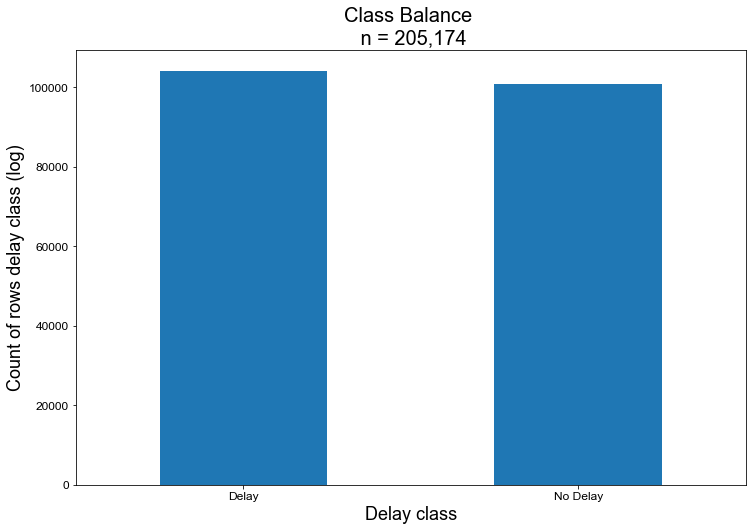

In [19]:
fig, ax = plt.subplots();
sample['delayed'].value_counts().plot(kind ='bar', figsize = (12,8));
ticks = ax.get_xticks()
sns.set_style('darkgrid')
plt.title(f'Class Balance \n n = {sample.shape[0] :,}', size = 20);
plt.xticks(ticks = ticks, labels =['Delay','No Delay'], rotation = 0, fontsize = 12)
plt.xlabel('Delay class', size = 18 )
plt.ylabel('Count of rows delay class (log)', size = 18 )
plt.yticks(fontsize = 12);
plt.savefig("../Assets/class_imbal.pdf", bbox_inches="tight")

## Categorical Column encoding
----
We will encode our categorical columns in this section and then join them to the numeric columns to establish our X values.

In [20]:
sample.columns

Index(['month', 'day_of_month', 'day_of_week', 'airline', 'tail_num',
       'op_carrier_fl_num', 'origin', 'dest', 'crs_dep_time', 'dep_time',
       'dep_delay', 'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'distance', 'markets', 'delayed'],
      dtype='object')

In [21]:
y = sample['delayed']
sample = sample.drop(columns = ['delayed'])

In [22]:
#need to remove related delay columns to prevent data leakage.
drop = [col for col in sample.columns if 'delay' in col]
drop_c = [col for col in sample.columns if 'cancel' in col]
drop, drop_c

(['dep_delay', 'arr_delay'], ['cancelled', 'cancellation_code'])

In [23]:
sample = sample.drop(columns = drop)
sample = sample.drop(columns = drop_c)

In [24]:
cat_cols = sample.select_dtypes(include=['object'])

In [25]:
cat_cols.shape

(205174, 13)

In [26]:
#need write a function that finds how many unique instances there are and print it out for each object column
# this will inform the complexity of OHE process.
def uniqueness(df, threshold=10):
    '''
    Measure the n_unique values for each categorical column. This will help us decide which columns to OHE. 
    Takes a dataframe as an arguement, and an integer to delinate the keep/drop decision. That is, if n_unique is too complex (above threshold), then consider dropping. 
    The function prints results and returns a keep and drop list of columns. 
    '''
    col_keep = []
    col_keep_count = []
    col_drop = []
    col_drop_count = []
    for col in df.columns:
        ux = df[f'{col}'].nunique()
        print(f"Column-- \'{col}\' -- contains {ux} unique labels")
        if ux > threshold:
            col_drop.append(f'{col}')
            col_drop_count.append(ux)
        else:
            col_keep.append(f'{col}')
            col_keep_count.append(ux)
    print('*'*30)
    print(f"the total number of new OHE columns is {sum(col_keep_count)}")
    print('*'*30)
    return col_keep, col_drop

In [27]:
keepers, drop = uniqueness(cat_cols, 1000)
print('keep: ', keepers)
print('drop: ',drop)

Column-- 'month' -- contains 12 unique labels
Column-- 'day_of_month' -- contains 31 unique labels
Column-- 'day_of_week' -- contains 7 unique labels
Column-- 'airline' -- contains 17 unique labels
Column-- 'tail_num' -- contains 7443 unique labels
Column-- 'op_carrier_fl_num' -- contains 6872 unique labels
Column-- 'origin' -- contains 379 unique labels
Column-- 'dest' -- contains 374 unique labels
Column-- 'crs_dep_time' -- contains 1305 unique labels
Column-- 'dep_time' -- contains 1402 unique labels
Column-- 'crs_arr_time' -- contains 1399 unique labels
Column-- 'arr_time' -- contains 1440 unique labels
Column-- 'markets' -- contains 6520 unique labels
******************************
the total number of new OHE columns is 820
******************************
keep:  ['month', 'day_of_month', 'day_of_week', 'airline', 'origin', 'dest']
drop:  ['tail_num', 'op_carrier_fl_num', 'crs_dep_time', 'dep_time', 'crs_arr_time', 'arr_time', 'markets']


In [28]:
#I actually want to keep markets intact
#drop = drop[:-1]

In [29]:
#apply the drop values to X drop
sample = sample.drop(columns = drop)


In [30]:
sample.dtypes

month            object
day_of_month     object
day_of_week      object
airline          object
origin           object
dest             object
distance        float64
dtype: object

In [31]:
X = pd.get_dummies(sample, columns = keepers)

In [32]:
X.columns

Index(['distance', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       ...
       'dest_VEL', 'dest_VLD', 'dest_VPS', 'dest_WRG', 'dest_WYS', 'dest_XNA',
       'dest_XWA', 'dest_YAK', 'dest_YKM', 'dest_YUM'],
      dtype='object', length=821)

In [33]:
X.shape

(205174, 821)

In [34]:
[col for col in X.columns if "delay" in col]

[]

In [35]:
X.columns

Index(['distance', 'month_Apr', 'month_Aug', 'month_Dec', 'month_Feb',
       'month_Jan', 'month_Jul', 'month_Jun', 'month_Mar', 'month_May',
       ...
       'dest_VEL', 'dest_VLD', 'dest_VPS', 'dest_WRG', 'dest_WYS', 'dest_XNA',
       'dest_XWA', 'dest_YAK', 'dest_YKM', 'dest_YUM'],
      dtype='object', length=821)

Our task is to utilize a supervised learning model to make predictions. We want to limit the imbalance on the classes we are attempting to predict so, we are left with some decisions to make on our dataset. 

### Training and Target variables set up.
----
Our features and target variables were encoded in the previous section. 

In [36]:
X.shape, y.shape

((205174, 821), (205174,))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=42)

In [39]:
X_train.shape, y_train.shape

((143621, 821), (143621,))

In [40]:
X_test.shape, y_test.shape

((61553, 821), (61553,))

## 4. Modeling and Performance
----
AdaBoost, LightGBM \* , XGBoost and Logistic Regression Classifiers were evaluated on common metrics. The results are compiled and then given in a table for comparison at which time a model is selected and then tuned in step 5. Each model is evaluated on their default settings on the notion that the model that performs best on their default settings would perform better after being tuned. 

In [45]:
cv_test = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [46]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

### 4.1 AdaBoost
----
The first model built will be one of our boosted classifiers. ADABoost



In [47]:
ada = AdaBoostClassifier(random_state = 42)

In [48]:
ada_scores = cross_validate(ada, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  3.2min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.5min finished


In [51]:
ada_scored = pd.DataFrame(ada_scores)#.add_prefix('Ada_train_')
print(ada_scored.mean())
ada_mean = pd.Series(ada_scored.mean(), name='AdaBoost_train')
ada_scored

fit_time          149.218789
score_time         15.405630
test_accuracy       0.572261
test_precision      0.573699
test_recall         0.612711
test_f1             0.592531
test_roc_auc        0.600139
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,171.258041,15.549609,0.570305,0.572165,0.608696,0.589865,0.600080
1,168.454496,16.820142,0.570046,0.569837,0.624237,0.595798,0.597311
2,167.090668,17.044770,0.574119,0.577247,0.601673,0.589207,0.602799
3,169.430152,16.455963,0.571682,0.572428,0.617379,0.594054,0.598780
4,167.016035,16.990261,0.575477,0.577465,0.610178,0.593371,0.601890
5,168.001362,16.693149,0.574447,0.574385,0.624331,0.598318,0.602897
6,169.591702,16.397048,0.573214,0.573555,0.620876,0.596279,0.598512
7,167.767380,16.943685,0.569559,0.570136,0.617996,0.593102,0.594237
8,125.347286,14.246409,0.572970,0.574194,0.614361,0.593599,0.602376
9,125.458194,14.193296,0.573562,0.577198,0.597901,0.587367,0.603379


### 4.2 Light GBM
----


In [52]:
light = LGBMClassifier(random_state=42)

In [53]:
light_scores = cross_validate(light, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.5s finished


In [54]:
light_scored = pd.DataFrame(light_scores)#.add_prefix('LGBMC_train')
print(light_scored.mean())
light_mean = pd.Series(light_scored.mean(), name = 'LGBM_train')
light_scored

fit_time          11.307615
score_time         2.082145
test_accuracy      0.588946
test_precision     0.590858
test_recall        0.618605
test_f1            0.604405
test_roc_auc       0.624587
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,12.848888,2.427536,0.589243,0.590705,0.621451,0.605688,0.622644
1,14.338835,2.284370,0.584389,0.586696,0.613332,0.599718,0.619897
2,14.411062,2.273804,0.591735,0.592124,0.629038,0.610023,0.629205
3,14.285000,2.305626,0.588671,0.591480,0.613264,0.602175,0.624184
4,14.255151,2.252912,0.591805,0.594657,0.615253,0.604780,0.625696
5,13.058565,2.356629,0.594430,0.595319,0.627897,0.611174,0.626665
6,14.316351,2.303853,0.590029,0.592483,0.616213,0.604115,0.624691
7,14.356550,2.284604,0.583728,0.585729,0.614773,0.599900,0.619695
8,7.187497,2.139223,0.587488,0.589445,0.617379,0.603088,0.625005
9,7.217371,2.135659,0.589855,0.591611,0.620053,0.605498,0.629042


### 4.3 XGBoost.
----
I am utilizing the [`hist` tree method]('https://xgboost.readthedocs.io/en/stable/treemethod.html') here to boost fit time performance. This is so we can mirror LightGBM's implementation of the algorithm. 

In [55]:
xg = XGBClassifier(tree_method = 'hist', random_state = 42)

In [56]:
xg_scores = cross_validate(xg, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   48.3s remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.5min finished


In [58]:
xg_scored = pd.DataFrame(xg_scores)#.add_prefix('XGB_train_')
print(xg_scored.mean())
xg_mean= pd.Series(xg_scored.mean(), name = 'XGB_train')
xg_scored

fit_time          39.787447
score_time         2.508643
test_accuracy      0.585975
test_precision     0.588334
test_recall        0.614092
test_f1            0.600932
test_roc_auc       0.619913
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,36.939865,3.028418,0.585448,0.588134,0.611850,0.599758,0.618093
1,42.441226,2.382401,0.581361,0.583814,0.610521,0.596869,0.615065
2,42.621170,2.404476,0.588671,0.590027,0.621631,0.605417,0.623881
3,42.525520,2.492905,0.584981,0.587328,0.613470,0.600114,0.619160
4,42.446896,2.411794,0.591596,0.593898,0.618133,0.605773,0.623640
5,36.709138,2.974277,0.587850,0.590272,0.615005,0.602385,0.620281
6,42.453988,2.496646,0.583519,0.585701,0.613538,0.599297,0.618285
7,42.604547,2.413136,0.586478,0.588803,0.614567,0.601409,0.619496
8,37.157751,2.937359,0.585817,0.587268,0.619368,0.602891,0.619228
9,37.122878,2.938422,0.585921,0.588616,0.612029,0.600094,0.623260


### 4.4 Logistic Regression
----


In [59]:
lr = LogisticRegression()

In [60]:
lr_scores = cross_validate(lr, X_train, y_train, scoring = metrics, cv = cv_test, n_jobs = -1, verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.2min remaining:   32.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.2min finished


In [149]:
lr_scored = pd.DataFrame(lr_scores)#.add_prefix('LogReg_train_')
print(lr_scored.mean())
lr_mean = pd.Series(lr_scored.mean(), name = 'LogReg_train') 
lr_scored

fit_time          64.059811
score_time         1.031001
test_accuracy      0.573486
test_precision     0.575740
test_recall        0.607307
test_f1            0.591070
test_roc_auc       0.601619
dtype: float64


,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,87.156284,0.788007,0.573821,0.575513,0.611507,0.592964,0.602228
1,83.690359,1.552896,0.571090,0.572846,0.609698,0.590698,0.598641
2,79.266425,0.969511,0.576521,0.578023,0.614018,0.595477,0.606266
3,54.694410,2.302601,0.569733,0.573324,0.595775,0.584334,0.597089
4,78.981843,0.978410,0.575930,0.577071,0.616213,0.596000,0.604039
5,84.539851,1.243736,0.577998,0.581349,0.602798,0.591879,0.605403
6,86.182740,0.950914,0.575338,0.577385,0.609698,0.593102,0.602199
7,77.634685,1.008410,0.572309,0.574131,0.609766,0.591413,0.597731
8,70.781485,0.657335,0.574363,0.574568,0.622248,0.597458,0.605582
9,35.422107,1.546311,0.571404,0.575475,0.593512,0.584355,0.601011


## 5. Model evaluation / selection

In [152]:
cohort = pd.concat([lr_mean, ada_mean, xg_mean, light_mean], axis=1)
cohort.T

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
LogReg_train,64.059811,1.031001,0.573486,0.575740,0.607307,0.591070,0.601619
AdaBoost_train,149.218789,15.405630,0.572261,0.573699,0.612711,0.592531,0.600139
XGB_train,39.787447,2.508643,0.585975,0.588334,0.614092,0.600932,0.619913
LGBM_train,11.307615,2.082145,0.588946,0.590858,0.618605,0.604405,0.624587


The model selected for this task is the LGBM model for its speed. In the next section we will run a grid search to find the best parameters so we may improve performance on our test set. 
Lets first see where we stand in so far as bias vs. variance is concerned. 

However, LGBM's classifier fails and causes a fatal error when calling the `.fit()` method. So, because of the inability of being able to fit on the data, XGBoost is the selected model going forward. 

### 5.1 XGBoost test fit and analysis. 
---
Initially, we are running this test fit to determine the state of the algorithm. That is we want to see if our model is overfitting and how it is finding the data. Likely this is overfit which can be addressed directly with parameter tuning. 

We will look at ROC AUC curve, confusion Matrix, and feature importances. 

In [103]:
xg2 =  XGBClassifier(tree_method = 'hist', random_state = 42)

In [104]:
xg.fit(X_train, y_train)

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x864 with 0 Axes>

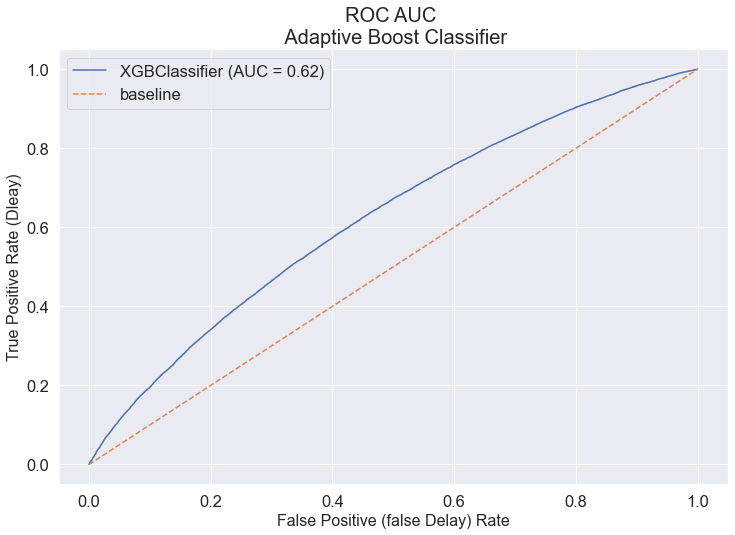

In [105]:
plt.rcParams["figure.figsize"] = (12,8);
plt.figure(figsize = (12,12))
plot_roc_curve(xg, X_test, y_test)
plt.title('ROC AUC \n Adaptive Boost Classifier',size =20)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.xlabel('False Positive (false Delay) Rate', size = 16)
plt.ylabel('True Positive Rate (Dleay)', size = 16)
plt.legend();
plt.savefig("../Assets/XGB_init_ROC_plot.pdf", bbox_inches="tight")

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


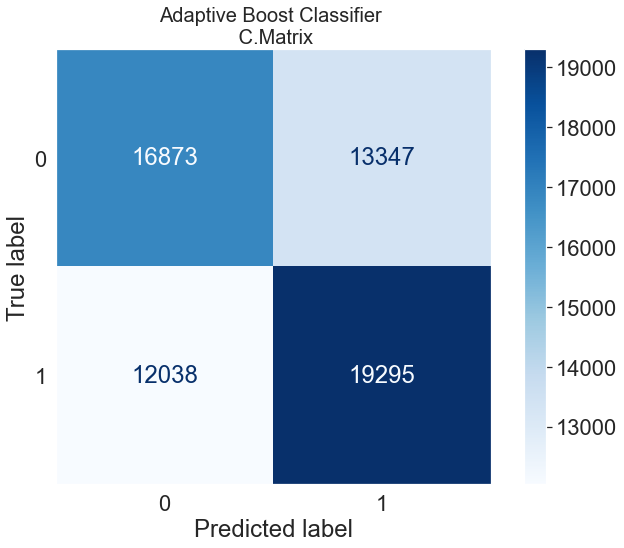

In [106]:
sns.reset_orig()
plt.rcParams["figure.figsize"] = (12,8);
sns.set_style('dark')
sns.set(font_scale=2)
plot_confusion_matrix(xg, X_test, y_test, cmap='Blues');
plt.grid(False)
plt.title('Adaptive Boost Classifier \n C.Matrix', size= 20);
plt.savefig("../Assets/XGB_init_confuse.pdf", bbox_inches="tight")

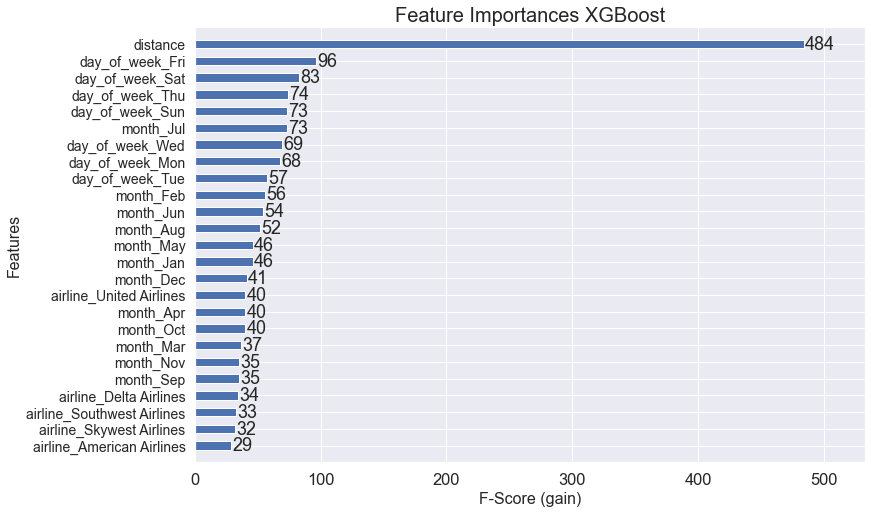

In [107]:
sns.reset_orig()
plt.rcParams["figure.figsize"] = (12,8);
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
plot_importance(xg, max_num_features=25, height = .5);
plt.title('Feature Importances XGBoost', size=20);
plt.xlabel('F-Score (gain)', size = 16);
plt.ylabel('Features', size = 16);
plt.yticks(fontsize =14);
plt.savefig("../Assets/XGB_init_F-import.pdf", bbox_inches="tight")

In [108]:
y_pred = xg.predict(X_test)

In [110]:
y_pred.shape

(61553,)

In [111]:
predictions = [round(value) for value in y_pred]

In [118]:
accuracy_test = accuracy_score(y_test, predictions)

In [119]:
accuracy_test

0.5875911815833509

In [122]:
xg.score(X_train, y_train)

0.6255561512592169

In [123]:
f1_score(y_test, predictions)

0.6032043767096523

In [ ]:
roc_auc_score, f1_score, precision_score, \
                            recall_score, plot_roc_curve,

In [155]:
scores = [accuracy_score,precision_score, recall_score, f1_score,roc_auc_score]


In [156]:
for score in scores:
    print(f'{round(score(y_test, predictions), 3)}')

0.588
0.591
0.616
0.603
0.587


In [157]:
round(cohort['XGB_train'],3)

fit_time          39.787
score_time         2.509
test_accuracy      0.586
test_precision     0.588
test_recall        0.614
test_f1            0.601
test_roc_auc       0.620
Name: XGB_train, dtype: float64

Discussion:
Each of these scores don't seem to be indicating an overfit. Honestly, I did not expect to have results so close to the train data. 
It seems that the complexity of the model and parameters seem to be doing well. 

What we are concerned about now is the overall accuracy and False Positive rate. Framed with our problem statement, we'd want to be highly accurate since we would like our end product to be useful for people to make decisions on. These decisions that would be made could cost our user's money and time. 

## 6. Tuning
---
The methods and some of the code were inspired by and used from [Daniel J Toth]('https://tothjd.medium.com') on their article [Binary Classification: XGBoost Hyperparameter Tuning Scenarios by Non-exhaustive Grid Search and Cross-Validation]('https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d') <br> Each code cell with signifcant influence will be marked as `Author: Daniel J. Toth`

In [166]:
xgb = XGBClassifier(tree_method= 'hist',learning_rate=0.1, max_depth=1)

In [167]:
xgb.fit(X_train, y_train)

/Users/nickvanbergen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:32:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [169]:
xgb.score(X_train, y_train)

0.5581077976061997

In [181]:
kf = KFold(n_splits=3, shuffle=True, random_state=1)
np.array(cross_val_score(xgb, X_test, y_test, cv=kf, n_jobs=-1)).mean()

0.5675596381987146

In [182]:
for num_trees in range(100, 1000, 100):
    xgb = XGBClassifier(n_estimators=num_trees, max_depth=1, use_label_encoder = False, verbosity = 0)
    print(num_trees, np.array(cross_val_score(xgb, X_test, y_test, cv=kf, n_jobs = -1)).mean())

100 0.5675596381987146
200 0.5711825431135226
300 0.5726121678767996
400 0.5733757456660871
500 0.5743180164550002
600 0.5746591692255599
700 0.5743342591856062
800 0.5746266956417406
900 0.5751628364030605


I will go with 200 as the optimal number of estimators for this problem. This will keep local processing times down

In [192]:
xgb_1 = XGBClassifier(n_estimators=200, tree_method='hist', use_label_encoder = False, verbosity = 0, eval_metric = 'logloss')

In [193]:

param_grid = {
    'max_depth': [1, 4, 7], 
    'min_child_weight': [1, 10, 100]
}
grid_search = GridSearchCV(
    xgb_1,
    param_grid=param_grid,
    cv=kf,
    n_jobs=-1,
    verbose = 3
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                        

In [194]:
grid_search.best_params_, grid_search.best_score_

({'max_depth': 7, 'min_child_weight': 10}, 0.5877204876586588)

In [203]:
xgb_2 = XGBClassifier(n_estimators=200, 
                      tree_method='hist', 
                      use_label_encoder = False,  
                      eval_metric = 'logloss', 
                      colsample_bytree = .5, 
                      colsample_bylevel = .5, 
                      colsample_bynode= .5
                     )

In [ ]:
param_grid = {
    'max_depth': [2, 5, 7, 9,15], 
    'min_child_weight': [10, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
}
grid_search = GridSearchCV(
    xgb_2,
    param_grid=param_grid,
    scoring = 'accuracy',
    cv=kf,
    n_jobs=-1,
    verbose = 10
)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [ ]:
grid_search.best_params_, grid_search.best_score_

In [162]:
#Author Daniel J Toth
#extracting default parameters from benchmark model
default_params = {}
gparams = xg.get_params()

In [163]:
#Author Daniel J Toth
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

In [161]:
default_params

{'objective': ['binary:logistic'],
 'use_label_encoder': [True],
 'base_score': [0.5],
 'booster': ['gbtree'],
 'colsample_bylevel': [1],
 'colsample_bynode': [1],
 'colsample_bytree': [1],
 'gamma': [0],
 'gpu_id': [-1],
 'importance_type': ['gain'],
 'interaction_constraints': [''],
 'learning_rate': [0.300000012],
 'max_delta_step': [0],
 'max_depth': [6],
 'min_child_weight': [1],
 'missing': [nan],
 'monotone_constraints': ['()'],
 'n_estimators': [100],
 'n_jobs': [8],
 'num_parallel_tree': [1],
 'random_state': [42],
 'reg_alpha': [0],
 'reg_lambda': [1],
 'scale_pos_weight': [1],
 'subsample': [1],
 'tree_method': ['hist'],
 'validate_parameters': [1],
 'verbosity': [None]}

In [ ]:
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.5],
              'max_depth': [2,5,6,7],
              'min_child_weight': [1, 10, 100]
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}